# GPT for Topic Categorization

In [63]:
import json
import pandas as pd
import numpy as np
import ast
import os
import re
from bs4 import BeautifulSoup
import csv
from tqdm.notebook import tqdm

import openai
from langchain.llms import OpenAI 
from langchain.chat_models import ChatOpenAI  
from langchain.callbacks import get_openai_callback
from langchain.schema.messages import HumanMessage, SystemMessage

## Load Data

EDAM topics, prompt, etc

In [3]:
with open("config.json", "r") as config_file:
    config = json.load(config_file)

In [4]:
openai_api_key = config["api_keys"]["openai"]

In [5]:
dataset = pd.read_csv(input("Enter testing dataset path: "))

In [6]:
dataset['MeSH Terms'] = dataset['MeSH Terms'].apply(lambda mesh_list: np.unique(ast.literal_eval((mesh_list))))
dataset['EDAM Topics'] = dataset['EDAM Topics'].apply(lambda edam_list: np.unique(ast.literal_eval((edam_list))))

In [8]:
with open('templates/prompt_template.txt', 'r') as template_file:
    template = template_file.read()

In [9]:
with open(input("Enter EDAM topics file:"), 'r') as edam_file:
    full_edam_topics = edam_file.readlines()

full_edam_topics = [topic.strip() for topic in full_edam_topics]

In [10]:
# Add EDAM topics to prompt template

formatted_topics = "\n".join(full_edam_topics)
template = template.replace("<topics>", formatted_topics)

### Plots

Remove non-unique terms from each row's EDAM topic list

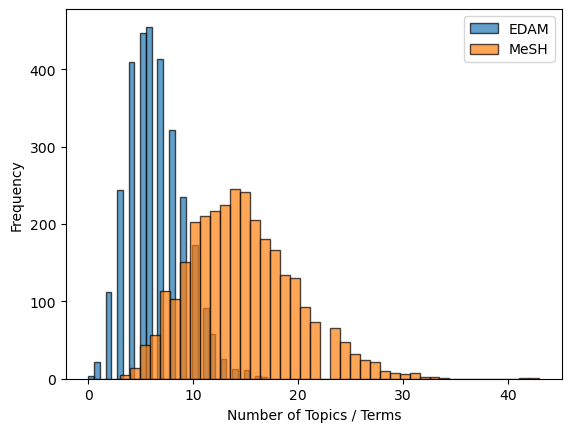

In [23]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black', alpha=0.7)
plt.hist(dataset['MeSH Terms'].apply(len), bins='auto', edgecolor='black', alpha=0.7)

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'MeSH'])

In [24]:
print("Total MeSH Terms:", len(list(dataset.iloc[0]['MeSH Terms'])))
print("Unique MeSH Terms:", len(np.unique(list(dataset.iloc[0]['MeSH Terms']))))
print()
print("Total EDAM Topics:", len(list(dataset.iloc[0]['EDAM Topics'])))
print("Unique EDAM Topics:", len(np.unique(list(dataset.iloc[0]['EDAM Topics']))))

Total MeSH Terms: 9
Unique MeSH Terms: 9

Total EDAM Topics: 7
Unique EDAM Topics: 7


### Remove any topics not in the EDAM Topics list

In [11]:
dataset['Filtered EDAM'] = dataset['EDAM Topics'].apply(lambda x: [item for item in x if item in full_edam_topics])

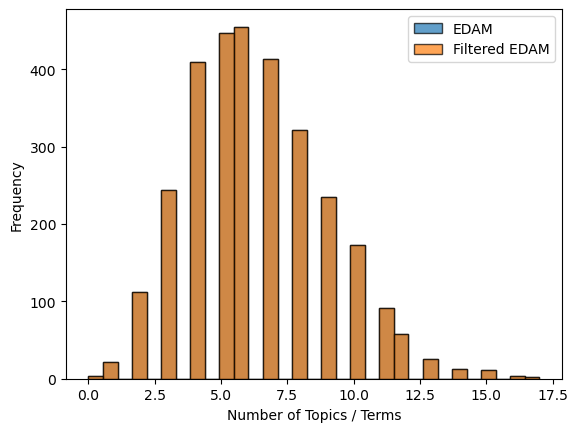

In [22]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black', alpha=0.7)
plt.hist(dataset['Filtered EDAM'].apply(len), bins='auto', edgecolor='black', alpha=0.7)

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'Filtered EDAM'])

In [12]:
# Check for any issues during filtering (missed topics, etc)

indices_true = dataset.loc[dataset['Filtered EDAM'].apply(lambda edam_list: not all(term in full_edam_topics for term in edam_list))].index

for index in indices_true:
    edam_list = dataset.loc[index, 'Filtered EDAM']
    terms_not_in_edam_topics = [term for term in edam_list if term not in full_edam_topics]
    
    print(f"Index {index}: Terms not in edam_topics: {terms_not_in_edam_topics}")

## OpenAI API

Let's start with a proof of concept:

In [ ]:
random_sample = dataset.sample(n=1)

index = random_sample.index[0]
description, abstract, paper_edam_topics = random_sample[['Description', 'Abstract', 'Filtered EDAM']].values[0]

In [ ]:
prompt = template.replace('<abstract>', abstract).replace('<num_terms>', str(len(paper_edam_topics)))
# prompt = template.replace('<description>', description).replace('<num_terms>', str(len(paper_edam_topics)))

In [ ]:
print(prompt)

In [ ]:
messages = [
    SystemMessage(content=f"You're a helpful assistant."),
    HumanMessage(content=prompt)
]

In [ ]:
chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    openai_api_key = openai_api_key
)

gpt_output = ''

with get_openai_callback() as cb:
    chat.invoke(messages)
    for chunk in chat.stream(messages):
        print(chunk.content, end="", flush=True)
        gpt_output += chunk.content
    print("\n===========CALLBACK: ==========\n")
    print(cb)
    print("\n=============\n")


# chat = OpenAI(
#     model_name='text-davinci-003',
#     openai_api_key = openai_api_key,
#     temperature=0.75
# )

# gpt_output = ''

# with get_openai_callback() as cb:
#     chat.invoke(messages)
#     for chunk in chat.stream(messages):
#         print(chunk, end="", flush=True)
#         gpt_output += chunk
#     print("\n===========CALLBACK: ==========\n")
#     print(cb)
#     print("\n=============\n")

In [ ]:
gpt_output

In [ ]:
not_in_edam = 0

true_topics = dataset.iloc[index]['Filtered EDAM']
num_correct = 0

for topic in gpt_output.strip().split(', '):
    if topic not in full_edam_topics:
        print(topic)
        not_in_edam += 1
        continue

    if topic in true_topics:
        num_correct += 1

In [ ]:
print("GPT-outputted topics not in EDAM:", not_in_edam)
print("# Correct topics from GPT:", num_correct)
print("# Incorrect topics from GPT:", len(true_topics) - num_correct)

In [ ]:
print(gpt_output, '\n')
print(', '.join(true_topics))

### Note: It seems as though GPT is not able to capture relevant topics given the entire list.

## Use GPT to capture major subtopics (Biology, Medicine, etc.)

We will see if GPT can capture the general topics of each data entry. Then we can pass the relevant subtopics.

https://bioportal.bioontology.org/ontologies/EDAM/?p=classes&conceptid=http%3A%2F%2Fedamontology.org%2Ftopic_0003

Biosciences - 4019

Chemistry - 3314

Computer science - 3316

Data management - 3071

Environmental Sciences - 3855

Informatics - 0605

Open science - 4010

Physics - 3318

In [ ]:
import pandas as pd

edam_data = pd.read_csv("EDAM/EDAM.csv")

edam_data = edam_data[edam_data['Parents'].str.contains("http://edamontology.org/topic_")]
edam_data['Parents #'] = edam_data['Parents'].str.extractall(r'topic_(\d+)').groupby(level=0).agg(lambda parents: parents.tolist())
edam_data['Topic #'] = edam_data['Class ID'].apply(lambda url: url.split('topic_')[1])

In [ ]:
from collections import defaultdict

topics = ['4019', '3314', '3316', '3071', '3855', '0605', '4010', '3318', '3361', '3068', '3678', '3315']

subtopics = defaultdict(lambda: [])

def get_children_topics(parent_id):
    # children_ids = edam_data[edam_data['Parents'].str.contains(parent_id)]['Class ID'].apply(lambda url: url.split('topic_')[1]).to_list()
    children_ids = edam_data[edam_data['Parents #'].apply(\
        lambda parent_ids: parent_id in parent_ids)]['Topic #'].to_list()
    
    if not len(children_ids):
        return []
    
    # print(parent_id, children_ids)
    
    grandchildren = []
    for child_id in children_ids:
        grandchildren.append(get_children_topics(child_id))
    
    children_ids.append(grandchildren)
    return children_ids

for parent_topic in topics:
    subtopics[parent_topic] = get_children_topics(parent_topic)

In [ ]:
def flatten_list(nested_list):
    flattened = []
    for item in nested_list:
        if isinstance(item, list):
            flattened.extend(flatten_list(item))
        else:
            flattened.append(item)
    return flattened

# Flatten each value in the dictionary
subtopics = {key: flatten_list(value) for key, value in subtopics.items()}

print()
for key, value in subtopics.items():
    print(f"{key}: {value}")

In [ ]:
topics_to_remove = ['3361', '3068', '3678', '3315']
topics_to_keep = ['4019', '3314', '3316', '3071', '3855', '0605', '4010', '3318']

for key in ['3361', '3068', '3678', '3315']:
    topics_to_remove.extend(subtopics[key])

for key in ['4019', '3314', '3316', '3071', '3855', '0605', '4010', '3318']:
    topics_to_keep.extend(subtopics[key])

topics_to_remove, topics_to_keep = set(topics_to_remove), set(topics_to_keep)

print('Number of Topics to remove: ', len([item for item in topics_to_remove if item not in topics_to_keep]))

edam_data = edam_data[~edam_data['Topic #'].apply(lambda topic: topic in topics_to_remove and topic not in topics_to_keep)]

# Remove the unnecessary topics =
for topic in ['3361', '3068', '3678', '3315']:
    del subtopics[topic]

print()
for key, value in subtopics.items():
    print(f"{key}: {value}")

In [ ]:
parent_topics = defaultdict(lambda: set())

for key, values in subtopics.items():
    for value in values:
        parent_topics[value].add(key)


for key, value in parent_topics.items():
    print(f"{key}: {value}")

In [ ]:
main_topics = {}

for topic in ['4019', '3314', '3316', '3071', '3855', '0605', '4010', '3318']:
    main_topics[topic] = edam_data[edam_data['Topic #'] == topic]['Preferred Label'].values[0]

main_topics

In [ ]:
edam_data['Parent Topics'] = edam_data['Topic #'].apply(lambda topic:[main_topics[parent_topic] for parent_topic in parent_topics[topic]])
edam_data['Parent Topics']

In [ ]:
dataset['Topic Category'] = dataset['Filtered EDAM'].apply(lambda edam_list: [edam_data[edam_data['Preferred Label'] == topic]['Parent Topics'].values[0] for topic in edam_list])\
    .apply(lambda parent_list: set([item for sublist in parent_list for item in sublist]))

dataset['Topic Category']

## GPT for topic categories

In [ ]:
with open('templates/prompt_template.txt', 'r') as template_file:
    template = template_file.read()

formatted_topics = "\n".join(main_topics.values())
template = template.replace("<topics>", formatted_topics)

In [119]:
def get_accuracy(generated_topics, true_topics):
    num_correct = 0

    for topic in generated_topics.strip().split(', '):
        if topic in true_topics:
            num_correct += 1
    
    return num_correct / len(true_topics)

In [12]:
def test(chat, dataset, truth_column='Topic Category', iterations=10, seed=54):
    cost, accuracies = 0, []
    io_pairs = []

    random_samples = dataset.sample(n=iterations, random_state=seed)
    
    for idx, random_sample in tqdm(random_samples.iterrows()):

        index = random_sample.index[0]
        _, abstract, paper_edam_topics = random_sample.loc[['Description', 'Abstract', truth_column]]

        prompt = template.replace('<abstract>', abstract).replace('<num_terms>', str(len(paper_edam_topics)))

        messages = [
            SystemMessage(content=f"Generate a comma-separated list of relevant EDAM topics based on the provided abstract and topic categories."),
            HumanMessage(content=prompt)
        ]

        gpt_output = ''

        with get_openai_callback() as cb:
            chat.invoke(messages)
            for chunk in chat.stream(messages):
                if type(chat) == ChatOpenAI:
                    gpt_output += chunk.content
                elif type(chat) == OpenAI:
                    gpt_output += chunk
            
            cost += float(str(cb).split('$')[1])

        try:
            true_topics = dataset.iloc[index][truth_column]

            accuracies.append(get_accuracy(gpt_output, true_topics))
        except:
            print('Error encountered at index', index)

        io_pairs.append([abstract, ', '.join(true_topics), gpt_output])

    print('Average Accuracy:', np.mean(accuracies))
    print('Total Cost ($):', cost)

    return accuracies, cost, io_pairs

In [ ]:
chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    openai_api_key = openai_api_key
)

accuracies, cost, _ = test(chat, dataset, iterations=50)

In [ ]:
chat = OpenAI(
    model_name='text-davinci-003',
    openai_api_key = openai_api_key
)

accuracies, cost, _ = test(chat, dataset, iterations=50)

In [ ]:
chat = ChatOpenAI(
    model_name='gpt-4',
    openai_api_key = openai_api_key
)

accuracies, cost, _ = test(chat, dataset, iterations=50)

## Double num_topics 

Attempting to see if GPT will eventually get the correct topics

In [ ]:
random_sample = dataset.sample(n=1)

index = random_sample.index[0]
description, abstract, paper_edam_topics = random_sample[['Description', 'Abstract', 'Filtered EDAM']].values[0]

In [ ]:
prompt = template.replace('<abstract>', abstract).replace('<num_terms>', str(len(paper_edam_topics) * 2))
# prompt = template.replace('<description>', description).replace('<num_terms>', str(len(paper_edam_topics)))

In [ ]:
print(prompt)

In [ ]:
messages = [
    SystemMessage(content=f"You're a helpful assistant."),
    HumanMessage(content=prompt)
]

In [ ]:
chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    openai_api_key = openai_api_key
)

gpt_output = ''

with get_openai_callback() as cb:
    chat.invoke(messages)
    for chunk in chat.stream(messages):
        print(chunk.content, end="", flush=True)
        gpt_output += chunk.content
    print("\n===========CALLBACK: ==========\n")
    print(cb)
    print("\n=============\n")

In [ ]:
get_accuracy(gpt_output, paper_edam_topics)

In [ ]:
print(abstract, '\n')
print(gpt_output)
print(', '.join(random_sample['Filtered EDAM'].values[0]))

There seems to be some potential, but requires further exploration. The main question to focus on is the definition of success, and how to measure whether the predicted topics are valid.

## Fine-Tuning GPT

We will start with 50 training samples for fine-tuning. (https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset)

In [302]:
n = 100

training_data = dataset.sample(n=n, replace=False, random_state=50)
training_data.shape

(100, 7)

In [ ]:
with open(f"datasets/finetune-data-{n}.jsonl", 'w') as file:
    for idx, row in training_data.iterrows():
        description, abstract, paper_edam_topics = row[['Description', 'Abstract', 'Filtered EDAM']]
        prompt = template.replace('<abstract>', abstract).replace('<num_terms>', str(len(paper_edam_topics)))

        json_data = {
            "messages": [
                {"role": "system", "content": "Generate a comma-separated list of relevant EDAM topics based on the provided abstract and topic categories."},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": ', '.join(paper_edam_topics)}
            ]
        }

        file.write(json.dumps(json_data))
        file.write('\n')


Use ```Chat_finetuning_data_prep.ipynb``` to check for any errors in the data and to get the cost estimate. 

In [ ]:
client = openai.OpenAI(api_key=openai_api_key)

fileobj = client.files.create(
  file=open(f"datasets/finetune-data-{n}.jsonl", "rb"),
  purpose="fine-tune"
)

fileobj

In [ ]:
ftjob = client.fine_tuning.jobs.create(
  training_file=fileobj.id, 
  model="gpt-3.5-turbo-1106"
)

ftjob

In [ ]:
# Finished once fine_tuned_model is not None

client.fine_tuning.jobs.list(limit=10).data

In [ ]:
# Most recent job
ftjob = client.fine_tuning.jobs.list(limit=10).data[0]

In [ ]:
from io import BytesIO

training_results = pd.read_csv(BytesIO(client.files.content(ftjob.result_files[0]).content))[['step', 'train_loss', 'train_accuracy']]
training_results

In [ ]:
training_results['train_loss'].plot()
plt.title('Loss Plot')
plt.xlabel('Step')
plt.ylabel('Loss')

In [ ]:
training_results['train_accuracy'].plot()
plt.title('Accuracy Plot')
plt.xlabel('Step')
plt.ylabel('Accuracy')

## Testing All Models

Gather data for all the models

In [61]:
def test(chat, dataset, truth_column='Filtered EDAM', iterations=10, seed=54):
    cost, accuracies = 0, []
    io_pairs = []

    random_samples = dataset.sample(n=iterations, random_state=seed)
        
    for idx, random_sample in tqdm(random_samples.iterrows(), total=random_samples.shape[0]):

        abstract, paper_edam_topics = random_sample.loc[['Abstract', truth_column]]

        prompt = template.replace('<abstract>', abstract).replace('<num_terms>', str(len(paper_edam_topics)))

        messages = [
            SystemMessage(content=f"Generate a comma-separated list of relevant EDAM topics based on the provided abstract and topic categories."),
            HumanMessage(content=prompt)
        ]

        gpt_output = ''

        try:

            with get_openai_callback() as cb:
                chat.invoke(messages)
                for chunk in chat.stream(messages):
                    if type(chat) == ChatOpenAI:
                        gpt_output += chunk.content
                    elif type(chat) == OpenAI:
                        gpt_output += chunk
                
                cost += float(str(cb).split('$')[1])

            true_topics = dataset.loc[idx][truth_column]

            accuracies.append(get_accuracy(gpt_output, true_topics))
        except Exception as e:
            print('Error encountered at index', idx)
            print(e)

            return accuracies, cost, io_pairs

        io_pairs.append([abstract, ', '.join(true_topics), gpt_output])

    print('Average Accuracy:', np.mean(accuracies))
    print('Total Cost ($):', cost)

    return accuracies, cost, io_pairs

In [14]:
def get_accuracy(generated_topics, true_topics):
    num_correct = 0

    for topic in generated_topics.strip().split(', '):
        if topic in true_topics:
            num_correct += 1
    
    return num_correct / len(true_topics)

In [38]:
n = 100

training_data = dataset.sample(n=n, replace=False, random_state=50)
training_data.shape

(100, 7)

In [39]:
testing_data = dataset.drop(training_data.index)
testing_data['Abstract'] = testing_data['Abstract'].apply(lambda text: BeautifulSoup(text, "html.parser").get_text())

In [69]:
results = pd.DataFrame(columns=['Model', 'Abstract', 'Ground Truth', 'Predictions'])

In [307]:
# 100 training samples (11/06 version)

chat = ChatOpenAI(
    model_name='ft:gpt-3.5-turbo-1106:personal::8SDAGTmv',
    openai_api_key = openai_api_key, 
    request_timeout=120, 
    max_retries=12
    
)

accuracies, cost, io_pairs = test(chat, testing_data, truth_column='Filtered EDAM', iterations=25)

for abstract, ground_truth, predictions in io_pairs:
    row = {'Model': chat.model_name, 'Abstract': abstract, 'Ground Truth': ground_truth, 'Predictions': predictions}
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Average Accuracy: 0.20376767676767676
Total Cost ($): 0.0


In [308]:
# 100 training samples (06/13 version)

chat = ChatOpenAI(
    model_name='ft:gpt-3.5-turbo-0613:personal::8SD8i1on',
    openai_api_key = openai_api_key,
    request_timeout=120, 
    max_retries=12
)

accuracies, cost, io_pairs = test(chat, testing_data, truth_column='Filtered EDAM', iterations=25)

for abstract, ground_truth, predictions in io_pairs:
    row = {'Model': chat.model_name, 'Abstract': abstract, 'Ground Truth': ground_truth, 'Predictions': predictions}
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Average Accuracy: 0.2944083694083694
Total Cost ($): 0.44696400000000003


In [309]:
# 50 training samples (06/13 version)

chat = ChatOpenAI(
    model_name='ft:gpt-3.5-turbo-0613:personal::8SAHvdnS',
    openai_api_key = openai_api_key,
    request_timeout=120, 
    max_retries=12
)

accuracies, cost, io_pairs = test(chat, testing_data, truth_column='Filtered EDAM', iterations=25)

for abstract, ground_truth, predictions in io_pairs:
    row = {'Model': chat.model_name, 'Abstract': abstract, 'Ground Truth': ground_truth, 'Predictions': predictions}
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Average Accuracy: 0.2636940836940837
Total Cost ($): 0.44688400000000006


In [310]:
# Non-fine tuned version. Default dated model

chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    openai_api_key = openai_api_key,
    request_timeout=120, 
    max_retries=12
)

accuracies, cost, io_pairs = test(chat, testing_data, truth_column='Filtered EDAM', iterations=25)

for abstract, ground_truth, predictions in io_pairs:
    row = {'Model': chat.model_name, 'Abstract': abstract, 'Ground Truth': ground_truth, 'Predictions': predictions}
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Average Accuracy: 0.16812987012987013
Total Cost ($): 0.0558825


In [125]:
# Non fine-tuned GPT 4

chat = ChatOpenAI(
    model_name='gpt-4',
    openai_api_key = openai_api_key,
    request_timeout=120, 
    max_retries=12
)

accuracies, cost, io_pairs = test(chat, testing_data, truth_column='Filtered EDAM', iterations=25)

for abstract, ground_truth, predictions in io_pairs:
    row = {'Model': chat.model_name, 'Abstract': abstract, 'Ground Truth': ground_truth, 'Predictions': predictions}
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Average Accuracy: 0.1905151515151515
Total Cost ($): 1.13019


In [180]:
import csv

# Convert Predictions column to a set
results['Predictions'] = results['Predictions'].apply(lambda x: set(map(str.strip, next(csv.reader([x])))))

0     {Oncology, Drug development, Biomedical scienc...
1     {Evolutionary biology, Comparative genomics, D...
2     {Genetics, Molecular biology, Cell biology, Bi...
3     {Gene expression, Biology, Animal study, Neuro...
4     {Gene expression, Immunogenetics, Personalised...
5     {"Functional, regulatory and non-coding RNA", ...
6     {Transcription factors and regulatory sites, G...
7     {Biochemistry, Microbiology, Infectious diseas...
8     {Gene expression, Oncology, Epigenomics, Bioin...
9     {Transcription factors and regulatory sites, D...
10    {Developmental biology, Gene expression, Data ...
11    {Gene regulation, Epigenetics, Biochemistry, M...
12    {Carbon cycle, Microbial ecology, Biochemistry...
13    {Bioinformatics, Genomics, Molecular biology, ...
14    {Human biology, Bioinformatics, Genomics, Canc...
15    {Systems biology, Biomedical science, Virology...
16    {Cell biology, Developmental biology, Immunolo...
17                {Geology, Microbiology, Bioche

In [313]:
results.to_csv('raw_model_outputs.csv', index=False)

In [314]:
def print_dynamically(string, max_line_length=80):
    words = string.split()
    lines = []
    current_line = ""

    for word in words:
        if len(current_line) + len(word) + 1 <= max_line_length:
            current_line += word + " "
        else:
            lines.append(current_line)
            current_line = word + " "

    lines.append(current_line)

    for line in lines:
        print(line)

In [328]:
model, abstract, ground_truth, pred = results.sample(n=1).values[0]

print_dynamically(abstract)

print('\nModel:', model)

print('\nGround Truth EDAM Topics:')
print(ground_truth)

print('\nGPT Predicted EDAM Topics:')
print(pred)

Influenza A virus (IAV) and Streptococcus pyogenes (the group A Streptococcus; 
GAS) are important contributors to viral-bacterial superinfections, which 
result from incompletely defined mechanisms. We identified changes in gene 
expression following IAV infection of A549 cells. Changes included an increase 
in transcripts encoding proteins with fibronectin-type III (FnIII) domains, 
such as fibronectin (Fn), tenascin N (TNN), and tenascin C (TNC). We tested the 
idea that increased expression of TNC may affect the outcome of an IAV-GAS 
superinfection. To do so, we created a GAS strain that lacked the Fn-binding 
protein PrtF.2. We found that the wild-type GAS strain, but not the mutant, 
co-localized with TNC and bound to purified TNC. In addition, adherence of the 
wild-type strain to IAV-infected A549 cells was greater compared to the prtF.2 
mutant. The wild-type strain was also more abundant in the lungs of mice 24 
hours after superinfection compared to the mutant strain. Final

In [49]:
## Compare old template and new template in terms of hallucinations

halluc_scores = []

for idx, row in results.iterrows():
    preds, upd_preds = list(ast.literal_eval(row['Predictions'])), row['New Predictions'].split(', ')
    # print(preds)
    # print(upd_preds, '\n')
    pred_scores = [1 if pred not in full_edam_topics else 0 for pred in preds]
    pred_score = sum(pred_scores) / len(pred_scores)
    upd_pred_scores = [1 if pred not in full_edam_topics else 0 for pred in upd_preds]
    upd_pred_score = sum(upd_pred_scores) / len(upd_pred_scores)

    halluc_score = pred_score - upd_pred_score
    halluc_scores.append(halluc_score)

Text(0, 0.5, 'Frequency')

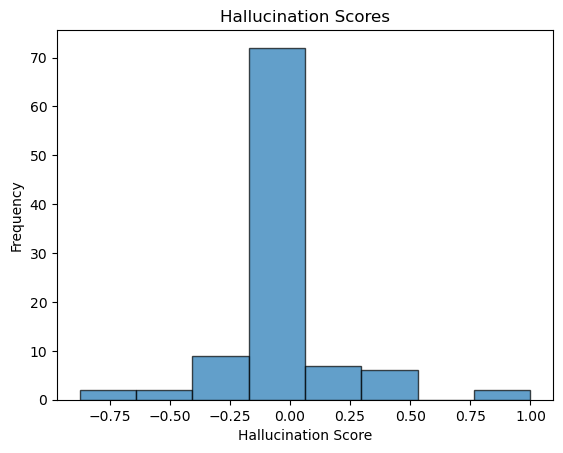

In [58]:
# Positive means old preds were worse, negative means they were better

plt.hist(halluc_scores, bins='auto', edgecolor='black', alpha=0.7)
plt.title('Hallucination Scores')
plt.xlabel('Hallucination Score')
plt.ylabel('Frequency')